# HW4: Structure-from-motion

ref: 
https://blog.csdn.net/haizimin/article/details/49836077,
https://github.com/MasteringOpenCV/code/tree/master/Chapter4_StructureFromMotion

In [97]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3

## 讀取圖片

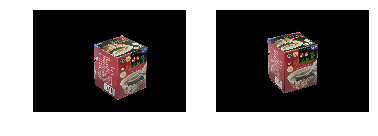

In [98]:
image1 = cv2.imread('./data/Mesona1.JPG')
image2 = cv2.imread('./data/Mesona2.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

## 計算相機內部參數

In [99]:
intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                              [0, 1.4219, 0.3802],
                              [0, 0, 0.0010]])
intrinsic_matrix_inverse1 = np.linalg.inv(intrinsic_matrix1)
print(intrinsic_matrix1)
print(np.transpose(intrinsic_matrix1))

[[  1.42190000e+00   5.00000000e-03   5.09200000e-01]
 [  0.00000000e+00   1.42190000e+00   3.80200000e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e-03]]
[[  1.42190000e+00   0.00000000e+00   0.00000000e+00]
 [  5.00000000e-03   1.42190000e+00   0.00000000e+00]
 [  5.09200000e-01   3.80200000e-01   1.00000000e-03]]


## 計算特徵點

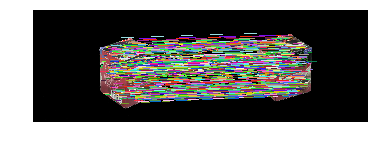

(<matplotlib.image.AxesImage at 0x1ddd56919b0>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [100]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## 計算Fundamental和Essential矩陣

In [101]:
def normalization(imgpts1, imgpts2):
    '''
        ref: lecture P.54
    '''
    # t1: image1 normalization matrix, t2: image2 normalization matrix
    t1, t2 = hw3.get_normalization_matrix(imgpts1, imgpts2)
    
    # to homography coordinate
    homopts1 = np.array([ [each[0], each[1], 1.0] for each in imgpts1])
    homopts2 = np.array([ [each[0], each[1], 1.0] for each in imgpts2])
    
    num_of_point = len(imgpts1)
    for i in range(num_of_point): 
        homopts1[i] = np.dot(t1, homopts1[i])
        homopts2[i] = np.dot(t2, homopts2[i])
    
    normalpts1 = np.delete(homopts1, -1, axis=1)
    normalpts2 = np.delete(homopts2, -1, axis=1)
    
    return normalpts1, normalpts2, t1, t2

def denormalize_fundamental_mat(normalMat1, normalMat2, normalize_fundamental):
    '''
        ref: Multiple View Geometry in Computer Vision - Algorithm 11.1
    '''
    return np.dot(np.dot(np.transpose(normalMat2), normalize_fundamental), normalMat1)

def get_fundamental(samplept1, samplept2):
    '''
        ref: Multiple View Geometry in Computer Vision - Chapter 11.1, lecture P.50
    '''
    
    # normalization the key points
    normalpts1, normalpts2, nomalmat1, normalmat2 = normalization(samplept1, samplept2)
    
    A = np.zeros((len(normalpts1), 9), dtype=np.float64)
    for i in range(len(normalpts1)):
        x, y = normalpts1[i][0], normalpts1[i][1]
        xi, yi = normalpts2[i][0], normalpts2[i][1]
        A[i] = np.array([xi*x, xi*y, xi, yi*x, yi*y, yi, x, y, 1])
    
    # resolve det(f) = 0
    u, s, v = np.linalg.svd(A)
    F = v[np.argmin(s)]
    F = F.reshape(3, 3)
    u, s, v = np.linalg.svd(F)
    s[-1] = 0
    F = u * s * v
    
    # denormalize the fundamental matrix
    fundamental_matrix = denormalize_fundamental_mat(nomalmat1, normalmat2, F)
    
    return fundamental_matrix

def get_geometric_error(testpts1, testpts2, fundamentalmat, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.4.3
    '''
    error = 0
    inliner_number = 0
    for i in range(len(testpts1)):
        x = np.array([testpts1[i][0], testpts1[i][1], 1])
        xi = np.array([testpts2[i][0], testpts2[i][1], 1])
        molecule = np.power(np.dot(np.dot(np.transpose(xi), fundamentalmat), x), 2)
        rp1 = np.dot(fundamentalmat, x)
        rp2 = np.dot(np.transpose(fundamentalmat), xi)
        denominator = np.power(rp1[1],2) + np.power(rp1[2],2) + np.power(rp2[1], 2) + np.power(rp2[2], 2)
        error += molecule / denominator
        if(error < inliner_threshold):
            inliner_number += 1
            
    return error, inliner_number

def get_essential_mat(intrinsicmat1, intrinsicmat2, fundamentalmat):
    '''
        ref: Multiple View Geometry 9.12
    '''
    return np.transpose(intrinsicmat1) * fundamental_matrix * intrinsicmat1

def find_fundamental_by_RANSAC(matchedpt_order, imgpts1, imgpts2, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.6
    '''
    ransac_iteration = 100
    ransac_sample_number = 8
    
    best_error = 999999
    best_fundamental = np.zeros((3,3))
    best_inlinernum = 0
    for i in range(ransac_iteration):
        sampts1, sampt2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
        f = get_fundamental(sampts1, sampt2)
        error, inlinernum = get_geometric_error(imgpts1, imgpts2, f, inliner_threshold)
        if(inlinernum > best_inlinernum):
            best_error = error
            best_fundamental = f
            best_inlinernum = inlinernum
    best_essential = get_essential_mat(intrinsic_matrix1, None, best_fundamental)
    print("RANSC error\n", best_error)
    return best_fundamental, best_essential

# find the fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamentamat, essentialmat = find_fundamental_by_RANSAC(matched_pt_order, imgpts1, imgpts2, 1)
print("F\n", fundamentamat)
print("E\n", essentialmat)

# by opencv
fundamentamat_opencv, _ = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, 1., 0.99, None)
essentialmat_opencv = get_essential_mat(intrinsic_matrix1, None, fundamentamat_opencv)
print("F by opencv\n", fundamentamat_opencv)
print("E by opencv\n", essentialmat_opencv)

RANSC error
 6.42943036709
F
 [[  5.28285641e-05   4.46698099e-05  -5.97296444e-02]
 [  1.19930352e-05   1.03599762e-05  -1.36568867e-02]
 [ -4.20001879e-02  -3.60549447e-02   4.77267600e+01]]
E
 [[ -7.36536316e-05   0.00000000e+00   0.00000000e+00]
 [ -0.00000000e+00   6.98246164e-06   0.00000000e+00]
 [ -0.00000000e+00  -0.00000000e+00  -1.53934306e-05]]
F by opencv
 [[  1.30170502e-07  -3.74285972e-07  -1.35177595e-03]
 [ -2.20353024e-06  -6.57283249e-08   2.48823660e-02]
 [  5.31704934e-04  -2.24088850e-02   1.00000000e+00]]
E by opencv
 [[ -7.36536316e-05   0.00000000e+00   0.00000000e+00]
 [ -0.00000000e+00   6.98246164e-06   0.00000000e+00]
 [ -0.00000000e+00  -0.00000000e+00  -1.53934306e-05]]


## Draw The Epipolar Lines

In [ ]:
def compute_correspond_epilines(keypts, which_image, fundamental):
    '''
       l = Fx'
       l' = F^Tx
    '''
    lines = np.zeros((len(keypts), 3))
    
    if (which_image == 2):
        np.transpose(fundamental)
    
    for i, p in enumerate(keypts):
        hp = np.array([p[0], p[1], 1])
        l = np.dot(fundamental, hp)
        a = l[0]
        b = l[1]
        check = a*a + b*b
        if check != 1:
            l = l / np.sqrt(check)
        lines[i] = l
    return lines

def draw_epilines(img1, img2, lines, pts1, pts2):
    '''
        ref: https://docs.opencv.org/3.4.4/da/de9/tutorial_py_epipolar_geometry.html
        x0, y0 = (0, -b/c)
        x1, y1 = (w, -(aw+c)/b)
    '''
    imgA = np.copy(img1)
    imgB = np.copy(img2)
    h, w, _ = img1.shape
    
    for r,pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = (0, int(-r[2]/r[1]))
        x1, y1 = (w, int(-(r[0]*w+r[2])/r[1]))
        imgA = cv2.line(imgA, (x0, y0), (x1, y1), color, 1)
        imgA = cv2.circle(imgA, (int(pt1[0]), int(pt1[1])), 5, color, -1)
        imgB = cv2.circle(imgB, (int(pt2[0]), int(pt2[1])), 5, color, -1)
    return imgA, imgB

# show image epilines
lines1 = compute_correspond_epilines(imgpts2, 2, fundamental_matrix)
print(lines1[0].shape)
img3, _ = draw_epilines(image1, image2, lines1, imgpts1, imgpts2)
lines2 = compute_correspond_epilines(imgpts1, 1, fundamental_matrix)
img4, _ = draw_epilines(image2, image1, lines2, imgpts2, imgpts1)

# by opencv
lines3 = cv2.computeCorrespondEpilines(imgpts2, 2, fundamentamat_opencv)
lines3 = lines3.reshape(-1,3)
img5, _ = draw_epilines(image1, image2, lines3, imgpts1, imgpts2)
lines4 = cv2.computeCorrespondEpilines(imgpts1, 1, fundamentamat_opencv)
lines4 = lines4.reshape(-1,3)
img6, _ = draw_epilines(image2, image1, lines4, imgpts2, imgpts1)

plt.figure(figsize=(10,10))
plt.subplot(321), plt.imshow(image1)
plt.subplot(322), plt.imshow(image2)
plt.subplot(323), plt.imshow(img4)
plt.subplot(324), plt.imshow(img3)
plt.subplot(325),plt.imshow(img6)
plt.subplot(326),plt.imshow(img5)
plt.show()

(3,)


## 計算Camera Matrix

In [105]:
# first camera matrix (ref: Multiple View Geometry 9.19)
camera_matrix1 = np.array([[1,0,0,0],
                           [0,1,0,0],
                           [0,0,1,0]])

def check_coherent_rotatio(rotation):
    if(abs(np.linalg.det(rotation))-1.0 > 1e-07):
        return False
    return True
_u, _s, _vt = np.linalg.svd(essential_matrix)
print("u\n", _u, "\ns\n", _s, "\nvh\n", _vt)

# skew-symmetric (ref: Multiple View Geometry 9.13)
w = np.array([[0, -1, 0], 
              [1, 0, 0], 
              [0, 0, 1]])

# 這裡有四種可能，需要點是否都在兩個相機前方(ref: Multiple View Geometry 9.14)
R2 = np.dot(np.dot(_u,w), _vt)
T2 = _u[:,2]
if(check_coherent_rotatio(R2) != True):
    camera_matrix2 = 0
else:
    camera_matrix2 = np.array([[R2[0,0], R2[0,1], R2[0,2], T2[0]],
                           [R2[1,0], R2[1,1], R2[1,2], T2[1]],
                           [R2[2,0], R2[2,1], R2[2,2], T2[2]]])
print("R2\n", R2)
print("T2\n", T2)
print("camera matrix2\n", camera_matrix2)

u
 [[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]] 
s
 [  7.36536316e-05   1.53934306e-05   6.98246164e-06] 
vh
 [[-1. -0. -0.]
 [-0. -0. -1.]
 [ 0.  1.  0.]]
R2
 [[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
T2
 [ 0.  1.  0.]
camera matrix2
 [[ 0.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [-1.  0.  0.  0.]]


## 將像素對應到三維空間

(800, 1200, 3)


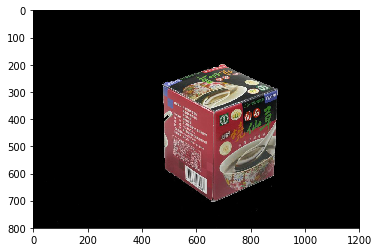

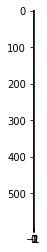

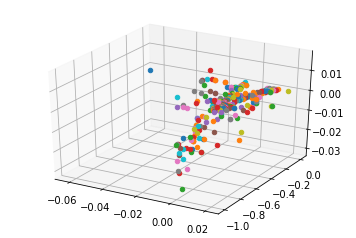

In [106]:
def linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2):
    '''
        ref: 1995 Triangulation, ch5.1 Linear Triangulation
    '''
    A = np.array([[(x1[0]*camera_matrix1[2,0]-camera_matrix1[0,0]), (x1[0]*camera_matrix1[2,1]-camera_matrix1[0,1]), (x1[0]*camera_matrix1[2,2]-camera_matrix1[0,2])],
                  [(x1[1]*camera_matrix1[2,0]-camera_matrix1[1,0]), (x1[1]*camera_matrix1[2,1]-camera_matrix1[1,1]), (x1[1]*camera_matrix1[2,2]-camera_matrix1[1,2])],
                  [(x2[0]*camera_matrix2[2,0]-camera_matrix2[0,0]), (x2[0]*camera_matrix2[2,1]-camera_matrix2[0,1]), (x2[0]*camera_matrix2[2,2]-camera_matrix2[0,2])],
                  [(x2[1]*camera_matrix2[2,0]-camera_matrix2[1,0]), (x2[1]*camera_matrix2[2,1]-camera_matrix2[1,1]), (x2[1]*camera_matrix2[2,2]-camera_matrix2[1,2])]])
    
    B = np.array([-(x1[0]*camera_matrix1[2,3]-camera_matrix1[0,3]),
                -(x1[1]*camera_matrix1[2,3]-camera_matrix1[1,3]),
                -(x2[0]*camera_matrix2[2,3]-camera_matrix2[0,3]),
                -(x2[1]*camera_matrix2[2,3]-camera_matrix2[1,3])])
    
    retbal, dst = cv2.solve(A,B, flags=cv2.DECOMP_SVD)
    return retbal, dst

def triangulate_points(keypt1, keypt2, camera_matrix1, camera_matrix2):
    
    points = np.zeros((len(keypt1), 3))
    reproject_errors = np.zeros(len(keypt1))
    for i in range(len(keypt1)):
    
        # convert to normalized homogeneous coordinates
        kp1 = keypt1[i]
        x1 = np.array([kp1[0], kp1[1], 1])
        x1m = np.dot(intrinsic_matrix_inverse1, x1)
        x1 = x1m
        
        # convert to normalized homogeneous coordinates
        kp2 = keypt2[i]
        x2 = np.array([kp2[0], kp2[1], 1])
        x2m = np.dot(intrinsic_matrix_inverse1, x2)
        x2 = x2m

        # triangulate
        state, X = linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2)
        points[i] = X[:,0]
        
        # calculate reprojection error
        #reproject_pt = np.dot(intrinsic_matrix1, camera_matrix2)
        #reproject_pt = np.dot(reproject_pt, X)
        #reproject_pt = ((reproject_pt[0]/reproject_pt[2]), (reproject_pt[1]/reproject_pt[2]))
        #reproject_errors[i] = reproject_pt
    #error = np.mean(reproject_errors)
    #print("error:", error)
    return points

three_points = triangulate_points(imgpts1, imgpts2, camera_matrix1, camera_matrix2)
print(image1.shape)

plt.imshow(image1), plt.show()
plt.imshow(imgpts1), plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, p in enumerate(three_points):
    xs = three_points[i][0]
    ys = three_points[i][1]
    zs = three_points[i][2]
    ax.scatter(xs, ys, zs)
plt.show()